### Some imports

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from keras.datasets import mnist

warnings.filterwarnings('ignore')

2024-05-13 18:40:16.421635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 18:40:16.451003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 18:40:16.989336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### An existing k-means algorithm with three different distance metrics

In [2]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

class KMeansWithCustomDistance(KMeans):
    def __init__(self, n_clusters, init, distance='euclidean', **kwargs):
        super().__init__(n_clusters=n_clusters, init=init, **kwargs)
        self.distance = distance

    def _pairwise_distances_argmin(self, X):
        if self.distance == 'euclidean':
            return np.argmin(euclidean_distances(X, self.cluster_centers_), axis=1)
        elif self.distance == 'manhattan':
            return np.argmin(manhattan_distances(X, self.cluster_centers_), axis=1)
        elif self.distance == 'cosine':
            return np.argmin(1 - cosine_distances(X, self.cluster_centers_), axis=1)
        else:
            raise ValueError(f"Invalid distance metric: {self.distance}")

### Get MNIST data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # load_data() function takes 60000 for training and 10000 for test. 
X_train = X_train.astype('float32') / 255.0 # normalize
X_train = X_train.reshape(60000, 28*28) # to dimension reducing with 784=28*28

# According to HW4, we need 56000 data, because get %80 training data, %20 test data, so 70.000 * 0.8 = 56.000, 
X_train = X_train[:5600] # for now, 5600 > %10
y_train = y_train[:5600]
X_test = X_test[:5600]
y_test = y_test[:5600]
kmeans = KMeansWithCustomDistance(n_clusters=10, init='k-means++', distance='manhattan')

### Get clusters

In [4]:
kmeans.fit(X_train)
labels_manhattan = kmeans.predict(X_train)
print("Cluster labels (Manhattan):", labels_manhattan)

centers_manhattan = kmeans.cluster_centers_
print("Cluster centers (Manhattan):", centers_manhattan)


Cluster labels (Manhattan): [7 3 9 ... 7 7 2]
Cluster centers (Manhattan): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### If you see the diagram, you will uncommit

In [5]:
#from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train)
# 
# kmeans.fit(X_train_pca)
# labels_manhattan_pca = kmeans.predict(X_train_pca)
# 
# centers_pca_manhattan = kmeans.cluster_centers_
# print(centers_pca_manhattan)
# 
# plt.figure(figsize=(10, 10))
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_manhattan_pca, cmap='viridis')
# plt.scatter(centers_pca_manhattan[:, 0], centers_pca_manhattan[:, 1], c='red', s=100, alpha=0.5)
# plt.title('Cluster Centers and Data Points (PCA)')
# plt.show()

## P.S.
But these are not real label of each image, since the output of the kmeans.labels_ is just group id for clustering. For example, 6 in kmeans.labels_ has similar features with another 6 in kmeans.labels_. There is no more meaning from the label.

To match it with real label, we can tackle the follow things:

- Combine each images in the same group
- Check Frequency distribution of actual labels (using np.bincount)
- Find the Maximum frequent label (through np.argmax), and set the label.

In [6]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [7]:
kmeans.fit(X_train)
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters_labels = kmeans.predict(X_train)
predicted_labels_with_argmax = infer_data_labels(X_clusters_labels, cluster_labels)

print(predicted_labels_with_argmax[:20])
print(y_train[:20])

[8 0 4 1 7 2 1 8 1 7 3 1 3 6 1 7 2 8 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


### If you see Kmeans performance for different cluster, you will uncommit

In [8]:
# from sklearn.metrics import accuracy_score
# 
# clusters = [10, 16, 36, 64, 144, 256]
# acc_list = []
# 
# for n_clusters in clusters:
#     estimator = KMeansWithCustomDistance(n_clusters=n_clusters, init='k-means++', distance='manhattan')
#     estimator.fit(X_train)
# 
#     # Determine predicted labels
#     cluster_labels = infer_cluster_labels(estimator, y_train)
#     prediction = infer_data_labels(estimator.labels_, cluster_labels)
#     
#     acc = accuracy_score(y_train, prediction)
#     acc_list.append(acc)
#     print('Accuracy: {}\n'.format(acc))

        Cluster1  Cluster2  Cluster3  Cluster4  Cluster5  Cluster6  Cluster7  \
Label0      32.0      43.0      33.0      40.0      44.0      39.0      38.0   
Label1      51.0      74.0      61.0      73.0      67.0      51.0      57.0   
Label2      39.0      41.0      30.0      29.0      37.0      22.0      30.0   
Label3      52.0      48.0      56.0      52.0      59.0      45.0      57.0   
Label4      39.0      26.0      25.0      33.0      30.0      30.0      40.0   
Label5      44.0      52.0      52.0      47.0      43.0      51.0      46.0   
Label6      37.0      51.0      41.0      48.0      53.0      38.0      47.0   
Label7      55.0      44.0      45.0      30.0      60.0      29.0      49.0   
Label8      33.0      56.0      49.0      39.0      35.0      28.0      31.0   
Label9      43.0      61.0      49.0      50.0      54.0      58.0      54.0   

        Cluster8  Cluster9  Cluster10  
Label0      41.0      42.0       40.0  
Label1      64.0      53.0       63.0  

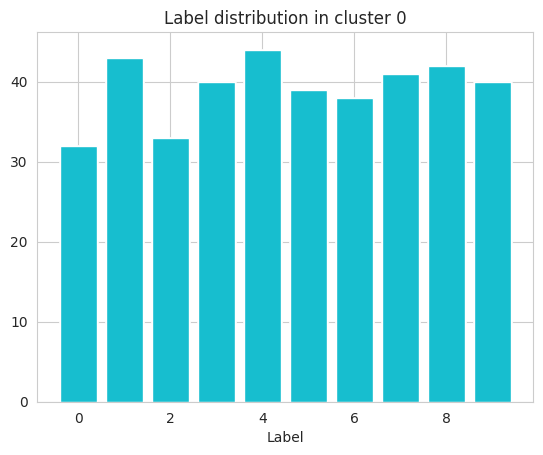

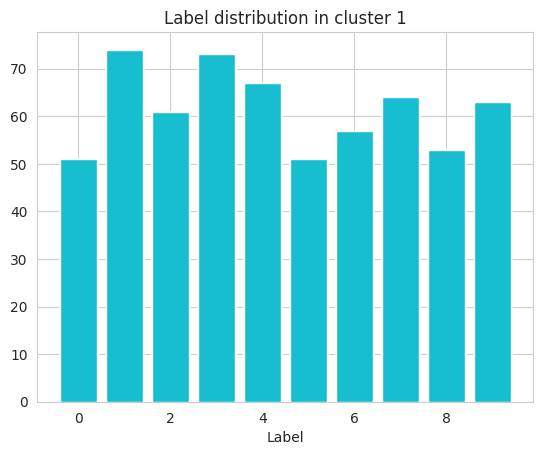

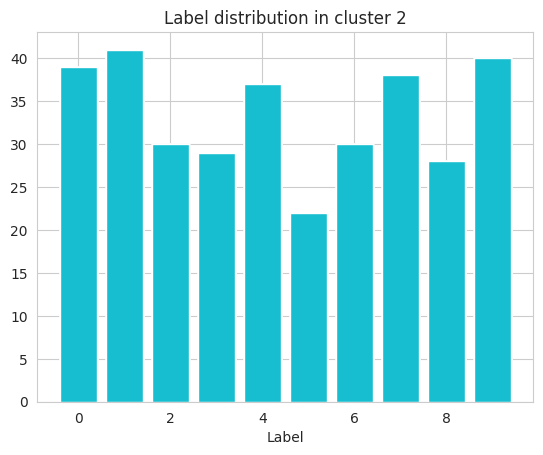

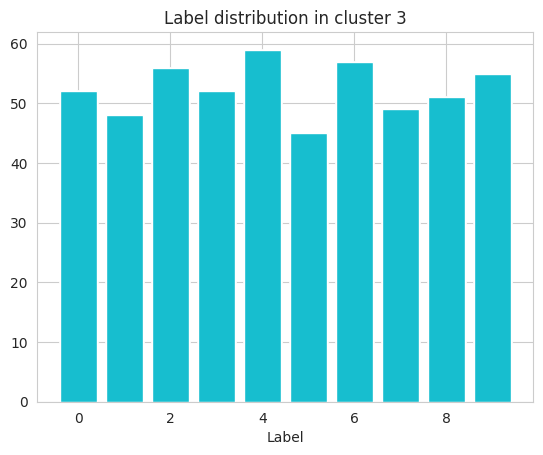

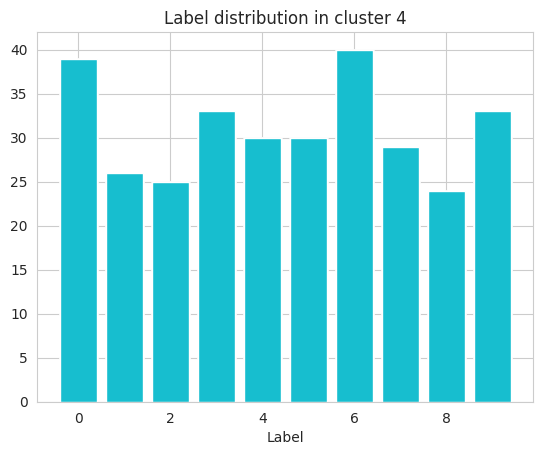

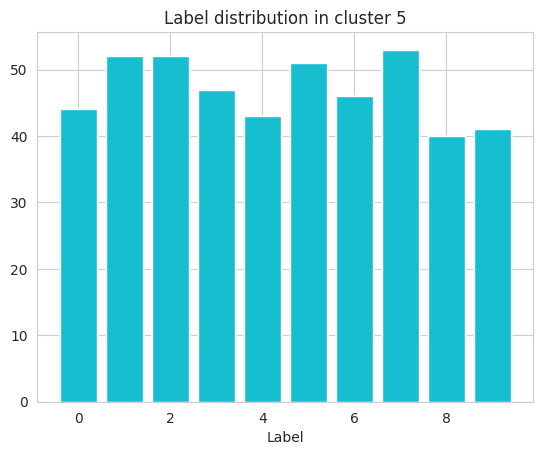

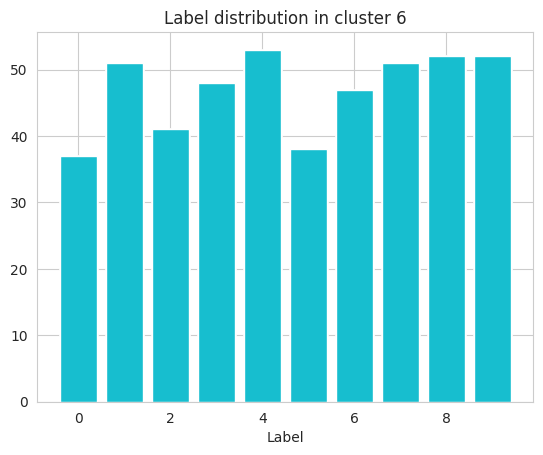

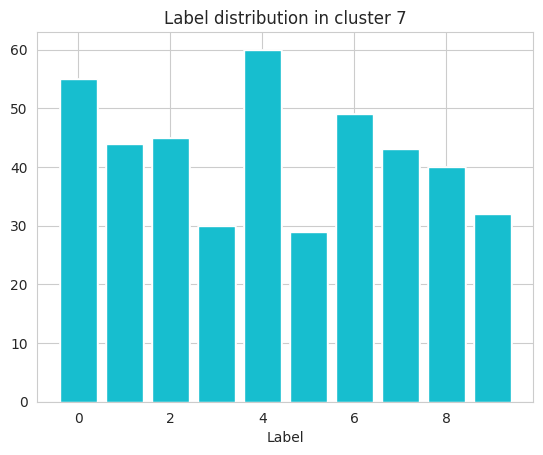

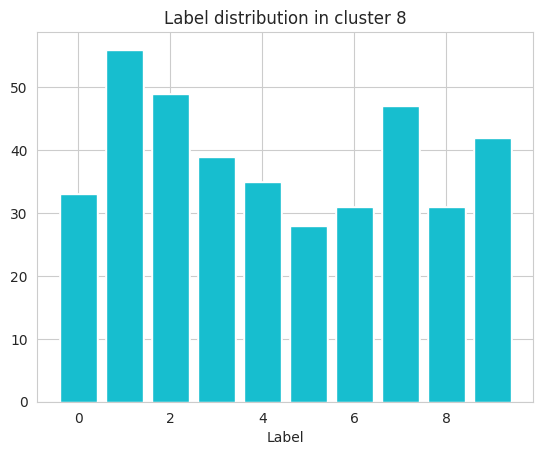

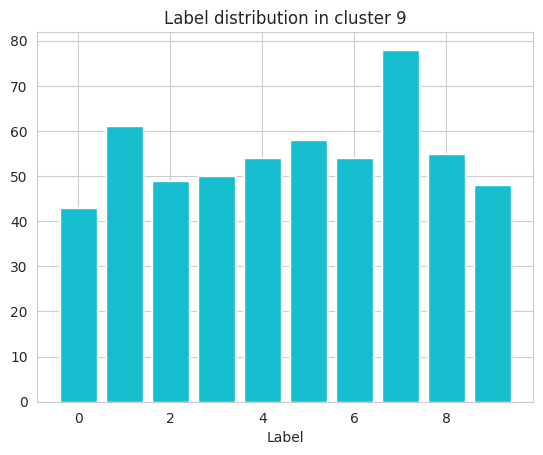

        Cluster1  Cluster2  Cluster3  Cluster4  Cluster5  Cluster6  Cluster7  \
Label0      20.0      31.0      33.0      34.0      40.0      33.0      42.0   
Label1      54.0      54.0      56.0      62.0      62.0      56.0      45.0   
Label2      34.0      33.0      31.0      35.0      39.0      24.0      34.0   
Label3      45.0      38.0      33.0      30.0      34.0      25.0      42.0   
Label4      45.0      76.0      62.0      65.0      67.0      62.0      68.0   
Label5      37.0      48.0      45.0      41.0      45.0      35.0      32.0   
Label6      60.0      56.0      60.0      47.0      59.0      44.0      52.0   
Label7      45.0      58.0      47.0      43.0      46.0      31.0      42.0   
Label8      48.0      43.0      34.0      43.0      38.0      41.0      47.0   
Label9      37.0      59.0      40.0      41.0      52.0      40.0      45.0   

        Cluster8  Cluster9  Cluster10  
Label0      27.0      29.0       25.0  
Label1      66.0      49.0       53.0  

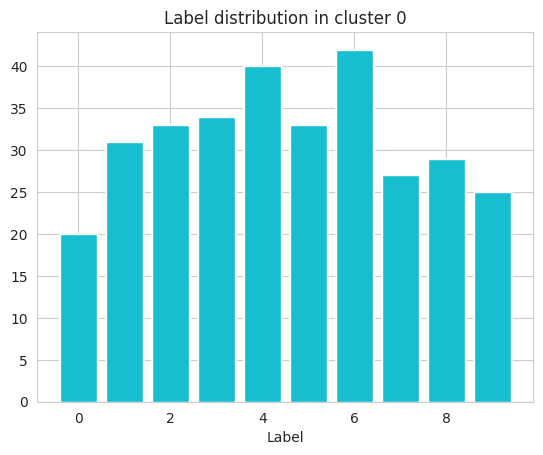

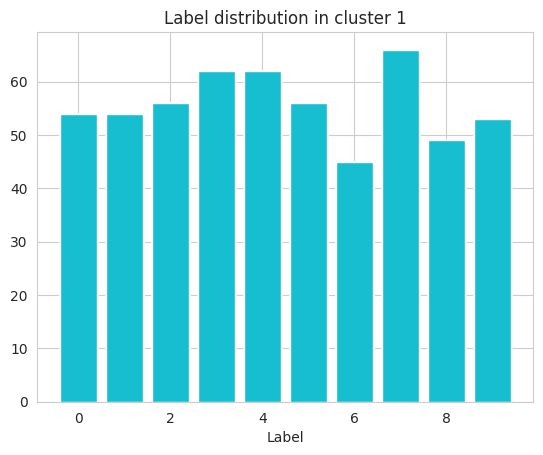

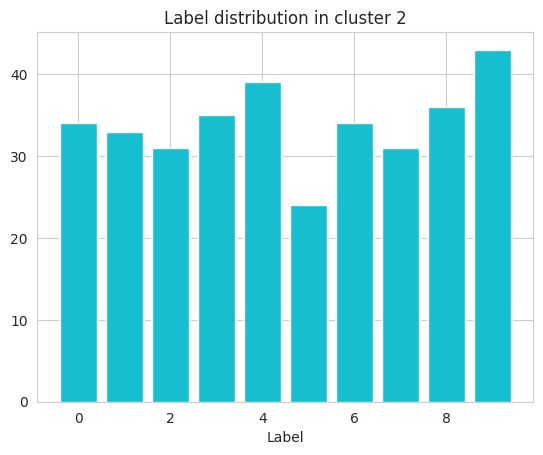

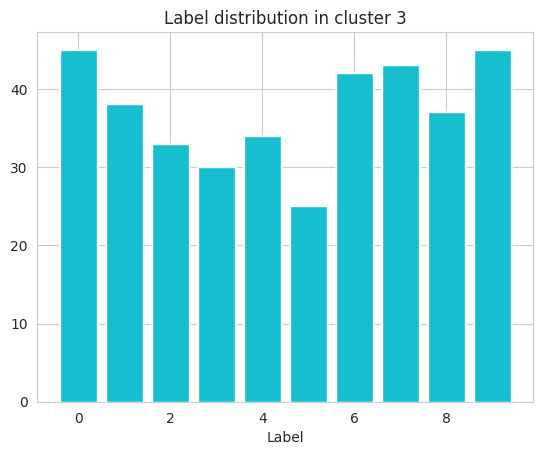

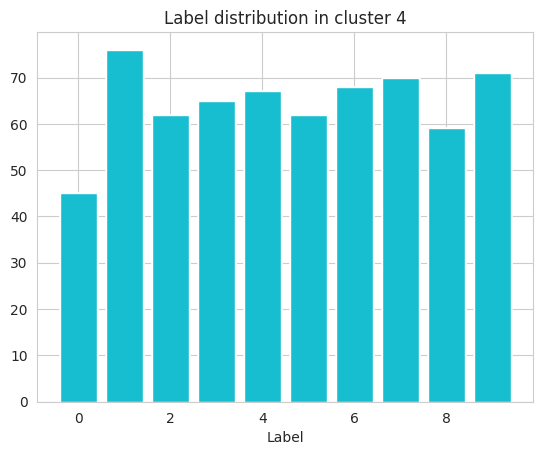

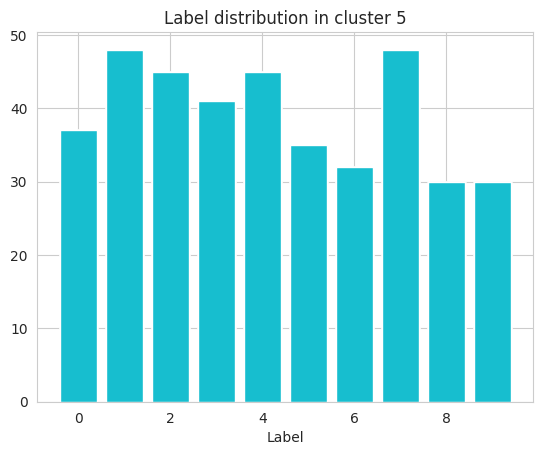

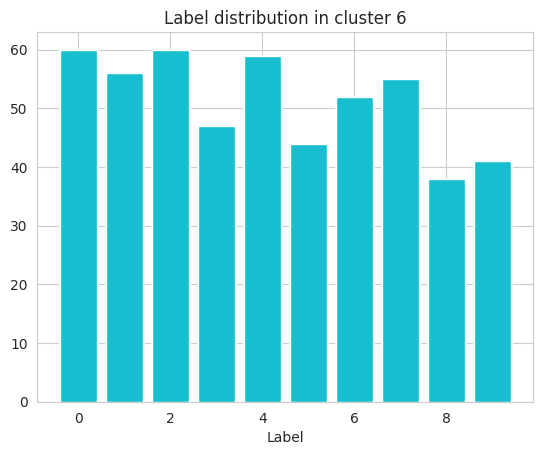

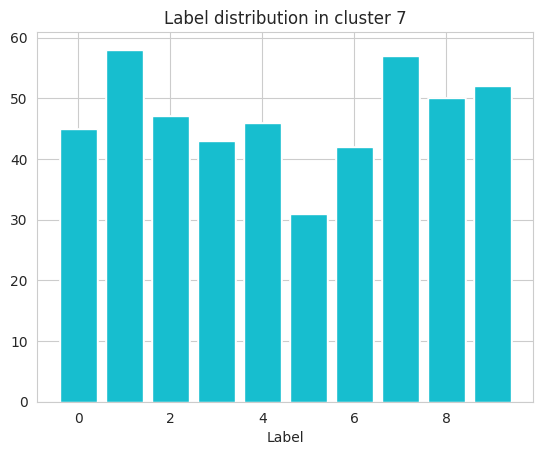

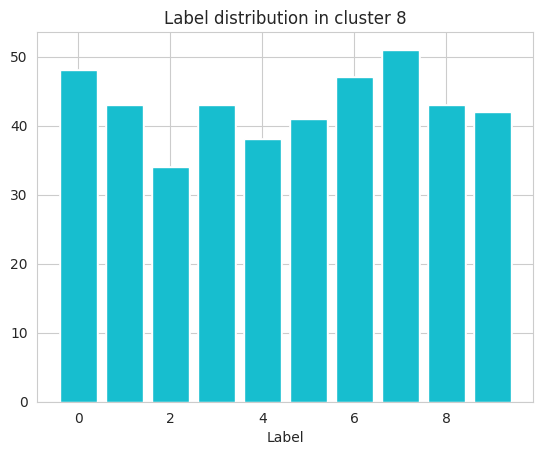

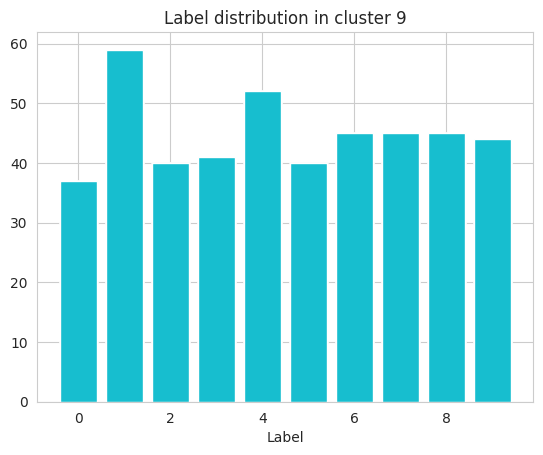

        Cluster1  Cluster2  Cluster3  Cluster4  Cluster5  Cluster6  Cluster7  \
Label0      35.0      39.0      33.0      31.0      49.0      33.0      42.0   
Label1      30.0      48.0      40.0      35.0      42.0      26.0      29.0   
Label2      29.0      41.0      27.0      36.0      34.0      29.0      27.0   
Label3      62.0      68.0      61.0      46.0      73.0      46.0      68.0   
Label4      37.0      46.0      42.0      35.0      37.0      38.0      45.0   
Label5      44.0      37.0      52.0      62.0      57.0      46.0      37.0   
Label6      44.0      62.0      46.0      53.0      45.0      41.0      52.0   
Label7      50.0      58.0      60.0      58.0      54.0      49.0      58.0   
Label8      35.0      42.0      30.0      34.0      39.0      29.0      33.0   
Label9      59.0      55.0      50.0      51.0      52.0      54.0      58.0   

        Cluster8  Cluster9  Cluster10  
Label0      40.0      36.0       38.0  
Label1      40.0      33.0       36.0  

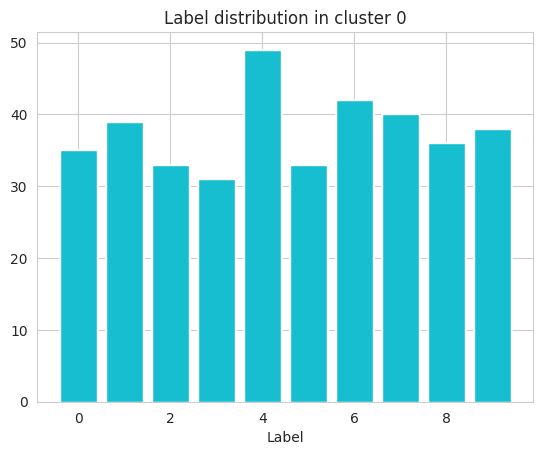

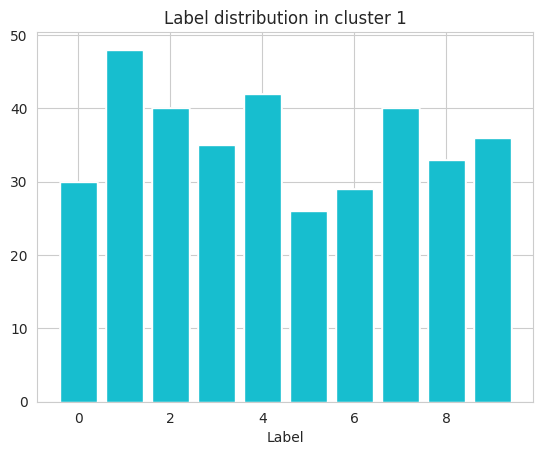

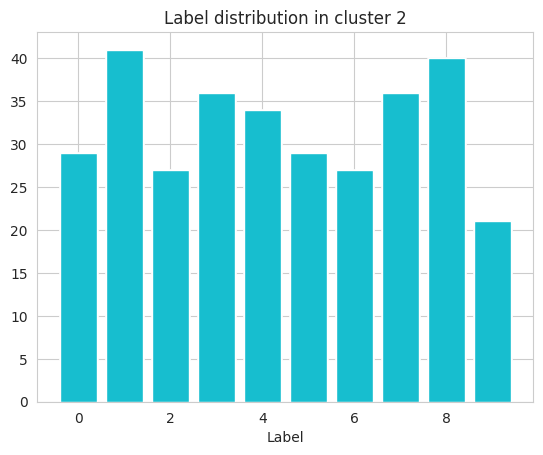

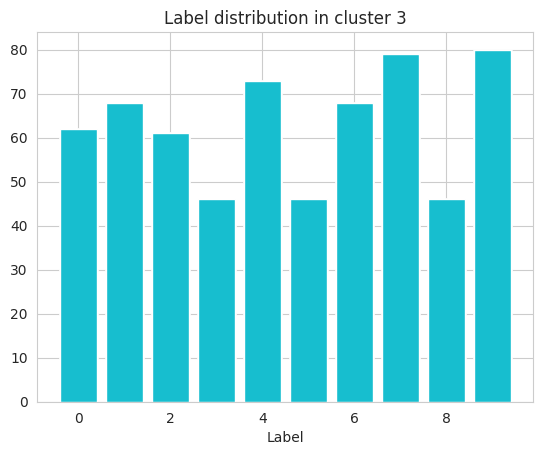

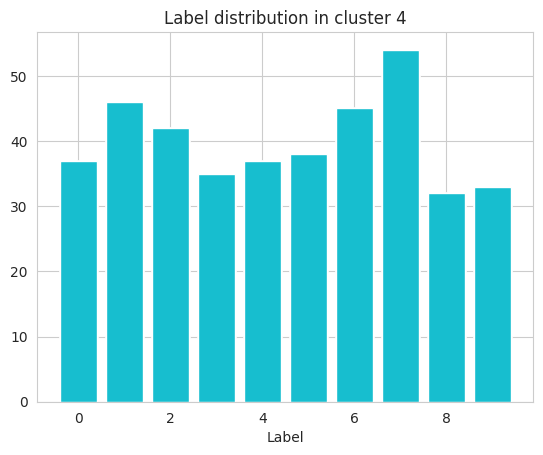

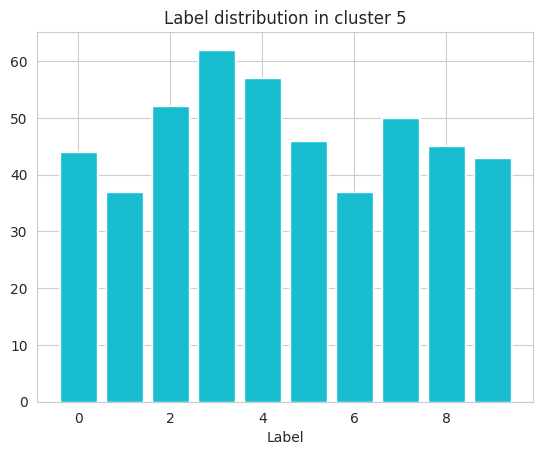

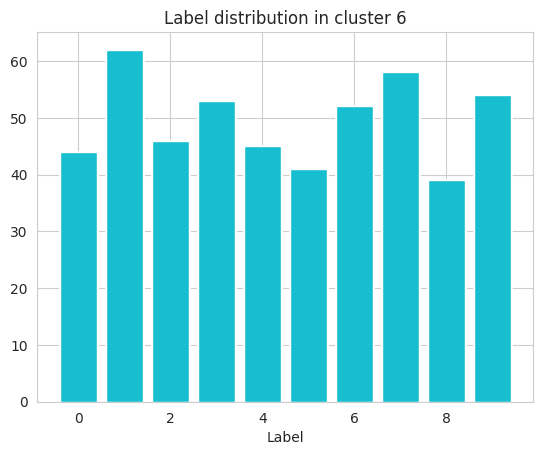

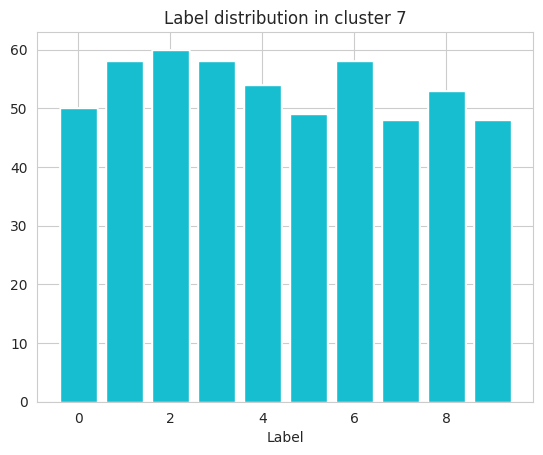

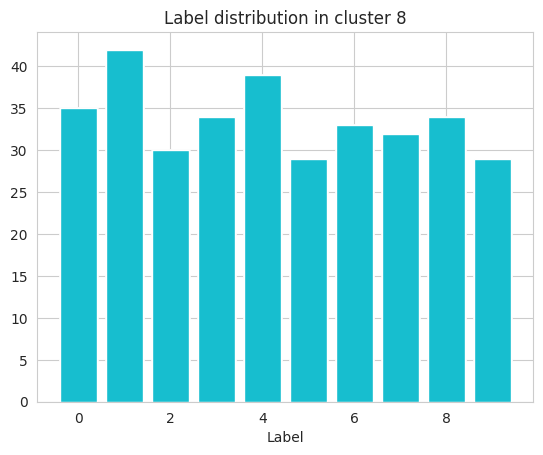

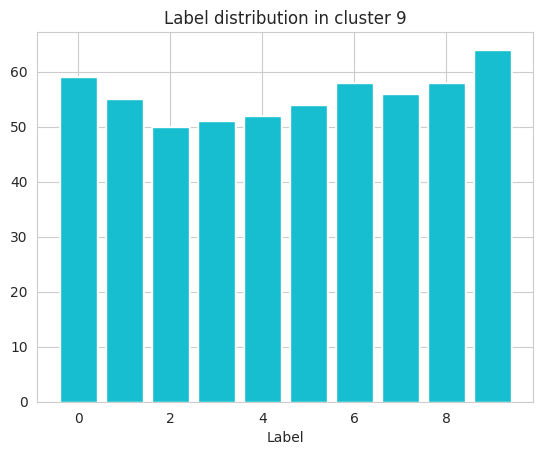

        Cluster1  Cluster2  Cluster3  Cluster4  Cluster5  Cluster6  Cluster7  \
Label0      33.0      36.0      30.0      30.0      37.0      28.0      29.0   
Label1      38.0      32.0      35.0      33.0      36.0      33.0      27.0   
Label2      54.0      64.0      57.0      48.0      57.0      38.0      53.0   
Label3      44.0      52.0      45.0      49.0      53.0      47.0      46.0   
Label4      43.0      55.0      44.0      57.0      50.0      41.0      46.0   
Label5      35.0      45.0      41.0      28.0      42.0      27.0      46.0   
Label6      36.0      49.0      42.0      38.0      37.0      41.0      39.0   
Label7      63.0      65.0      69.0      61.0      66.0      38.0      65.0   
Label8      44.0      54.0      47.0      56.0      62.0      59.0      64.0   
Label9      35.0      44.0      31.0      41.0      42.0      39.0      34.0   

        Cluster8  Cluster9  Cluster10  
Label0      28.0      36.0       34.0  
Label1      41.0      32.0       39.0  

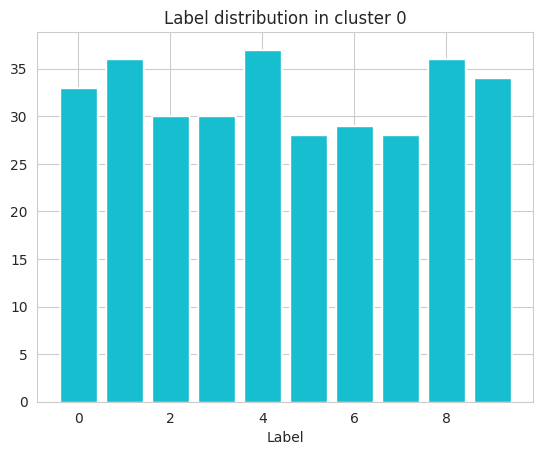

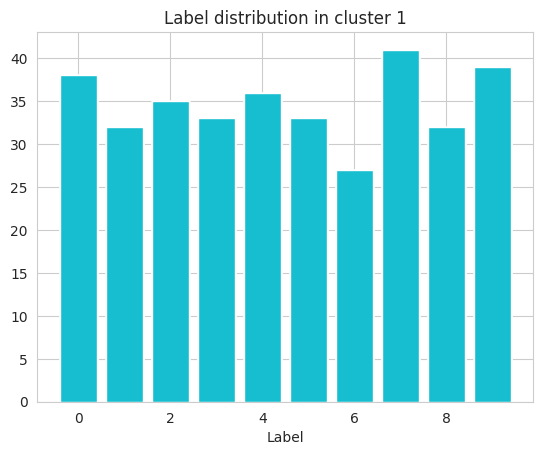

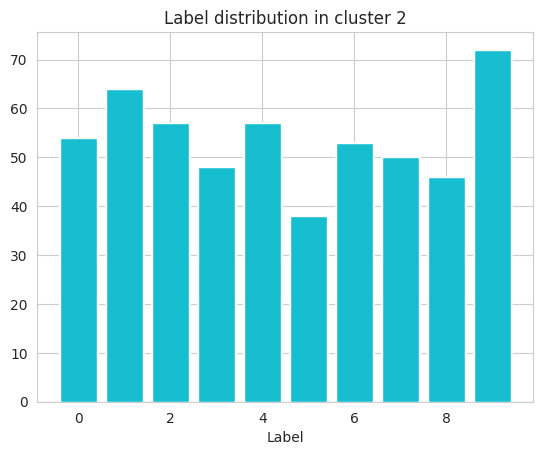

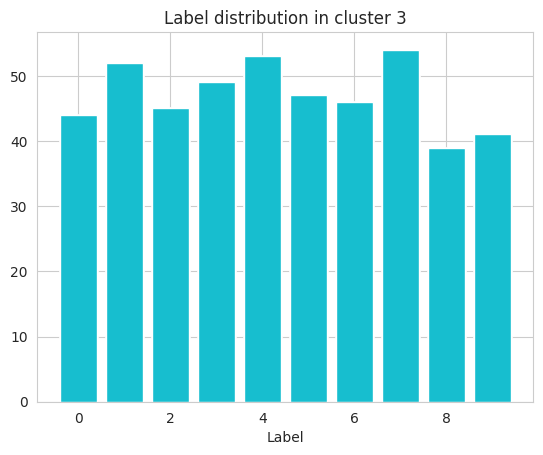

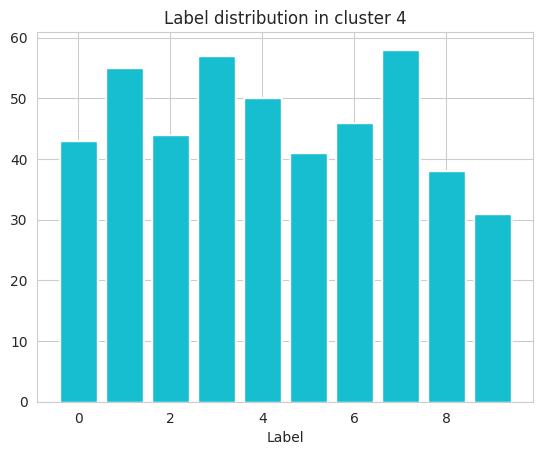

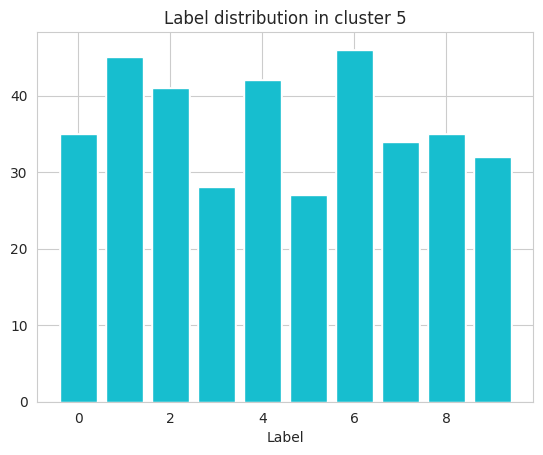

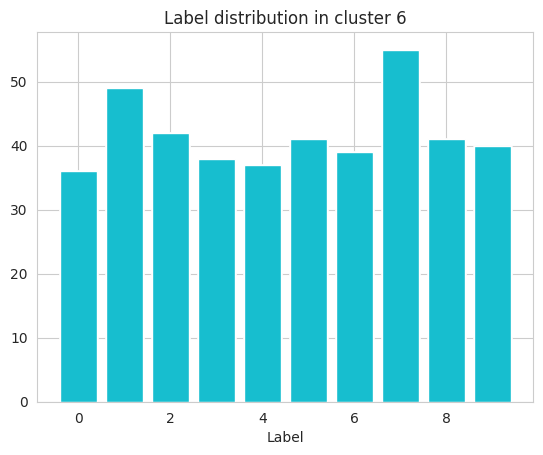

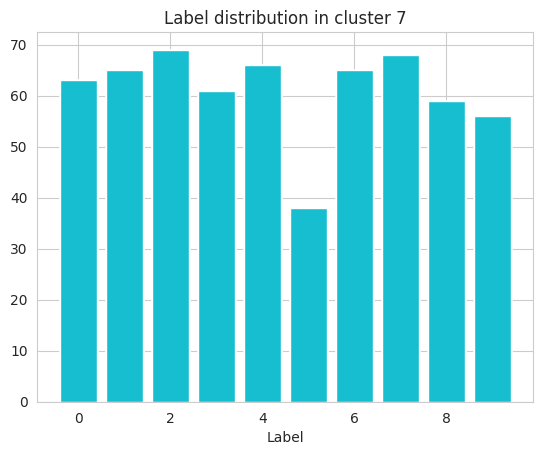

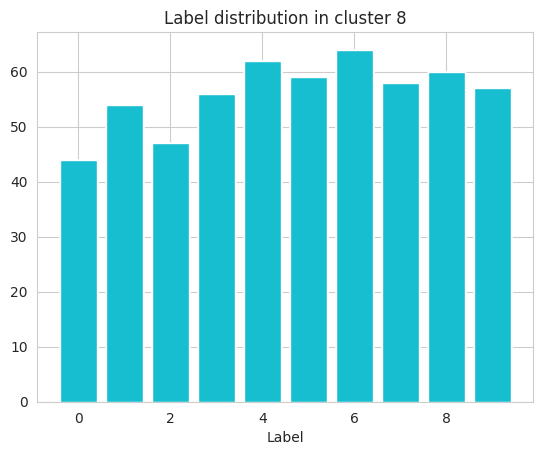

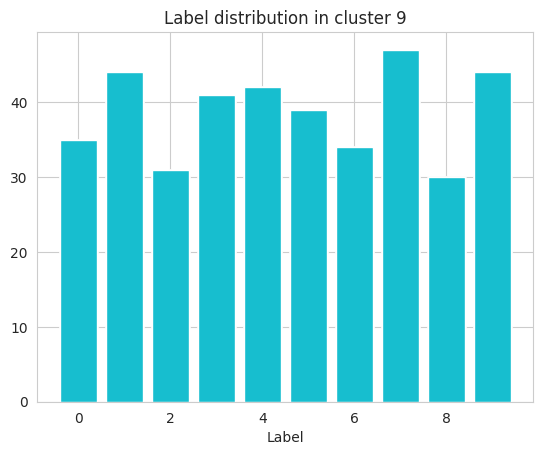

        Cluster1  Cluster2  Cluster3  Cluster4  Cluster5  Cluster6  Cluster7  \
Label0      32.0      38.0      35.0      26.0      36.0      27.0      25.0   
Label1      41.0      39.0      32.0      35.0      46.0      31.0      33.0   
Label2      75.0      69.0      64.0      67.0      82.0      47.0      83.0   
Label3      53.0      70.0      65.0      58.0      56.0      58.0      61.0   
Label4      33.0      35.0      51.0      52.0      47.0      41.0      37.0   
Label5      62.0      60.0      44.0      52.0      44.0      61.0      58.0   
Label6      54.0      72.0      71.0      66.0      72.0      54.0      67.0   
Label7      38.0      54.0      33.0      39.0      54.0      41.0      45.0   
Label8      15.0      23.0      22.0      17.0      24.0      18.0      20.0   
Label9      22.0      36.0      24.0      29.0      21.0      13.0      20.0   

        Cluster8  Cluster9  Cluster10  
Label0      33.0      30.0       31.0  
Label1      39.0      32.0       39.0  

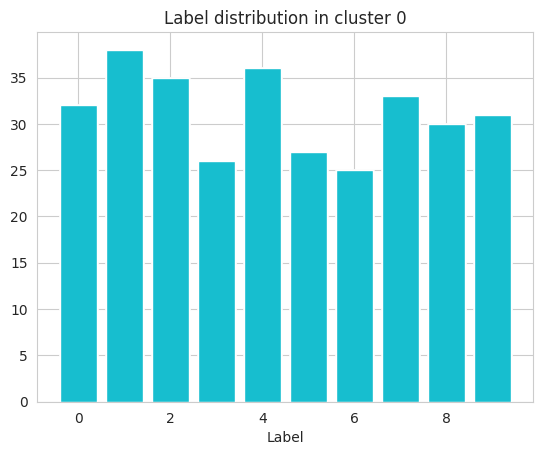

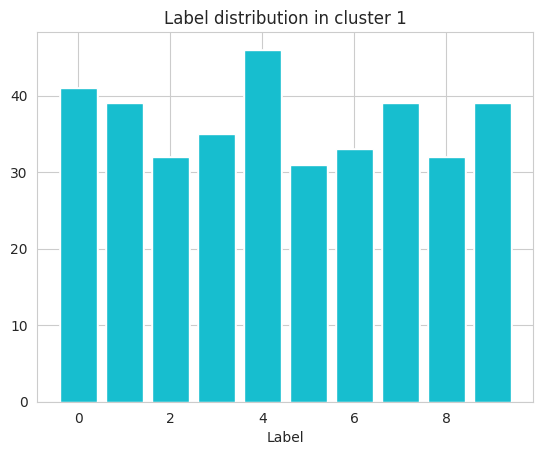

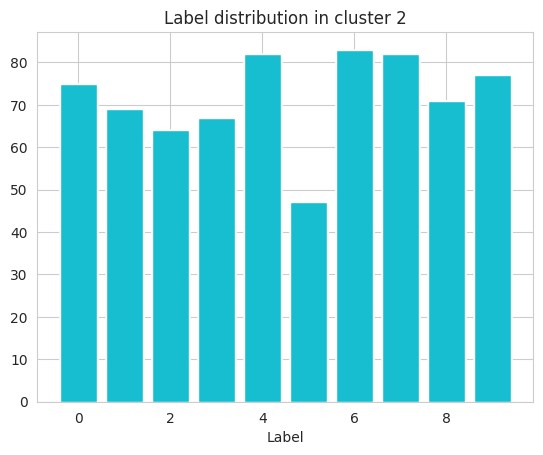

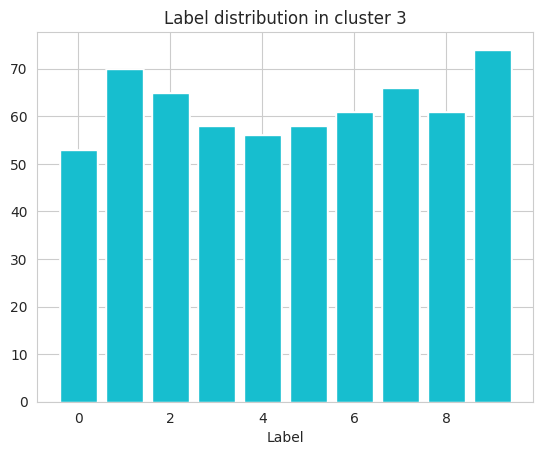

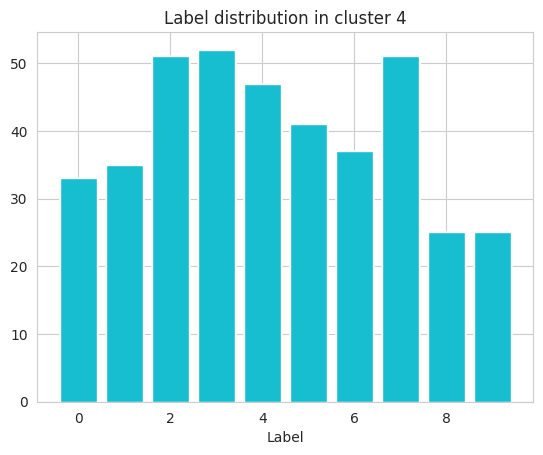

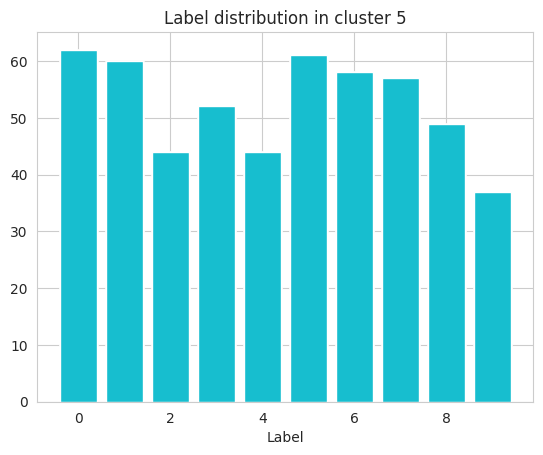

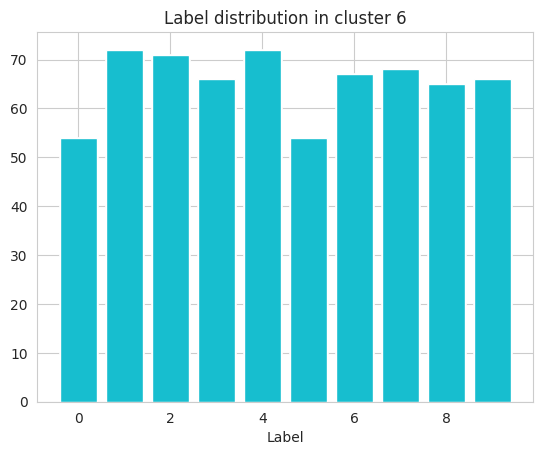

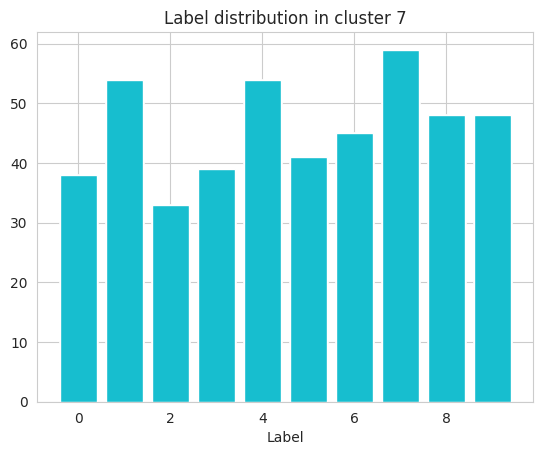

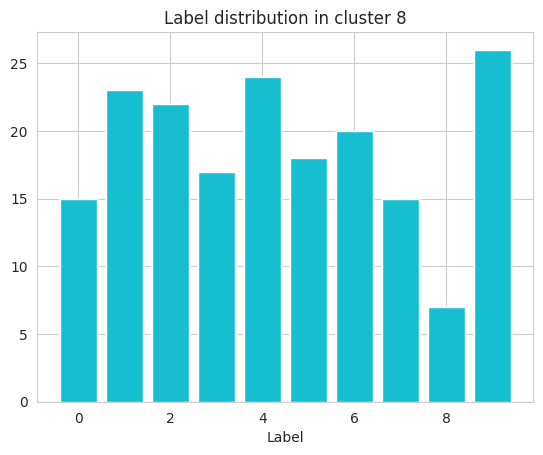

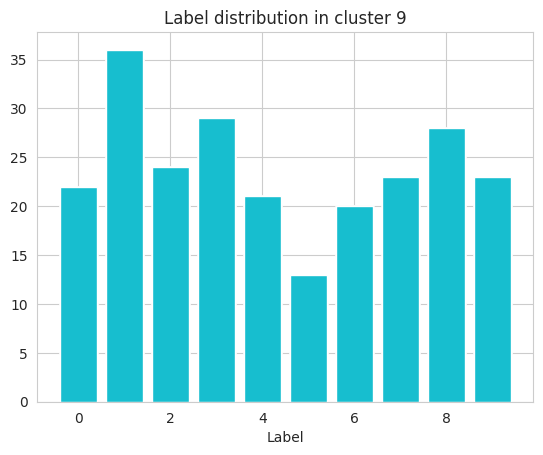

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
# pd.set_option('display.max_columns', 7)

row_labels = [f'Label{i}' for i in range(10)]
column_labels = [f'Cluster{i+1}' for i in range(10)]

accuracy_scores_for_trainin_error = []
confusion_matrices_for_trainin_error = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation this function gives me an index subset of X_train
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    kmeans.fit(X_train_fold)
    
    cluster_labels_fold = infer_cluster_labels(kmeans, y_train_fold)
    X_cluster_labels_fold = kmeans.predict(X_train_fold)
    predicted_labels_fold = infer_data_labels(X_cluster_labels_fold, cluster_labels_fold)

    clusters = kmeans.labels_
    label_counts = np.zeros((10, 10))
    
    for i in range(len(clusters)):
        label_counts[clusters[i]][y_train[i]] += 1
    
    print(pd.DataFrame(label_counts, index=row_labels, columns=column_labels))
    print()

    # if you want to hide all label distribution in clusters, you will comment this section
    for i in range(10):
        for j in range(10):
            plt.bar(range(10), label_counts[i])
            plt.title(f"Label distribution in cluster {i}")
            plt.xlabel("Label")
        plt.show()

    accuracy = accuracy_score(y_train_fold, predicted_labels_fold)
    cm = confusion_matrix(y_train_fold, predicted_labels_fold)

    accuracy_scores_for_trainin_error.append(accuracy)
    confusion_matrices_for_trainin_error.append(cm)

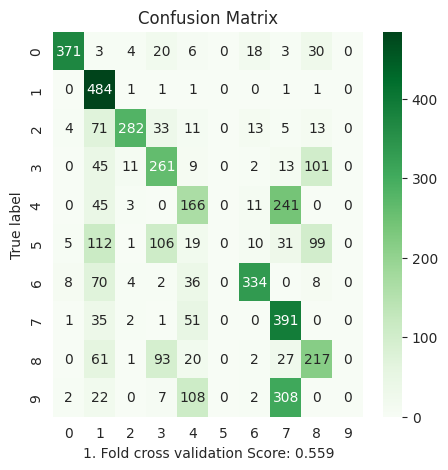

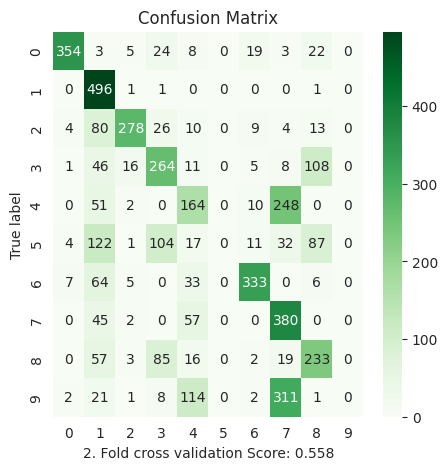

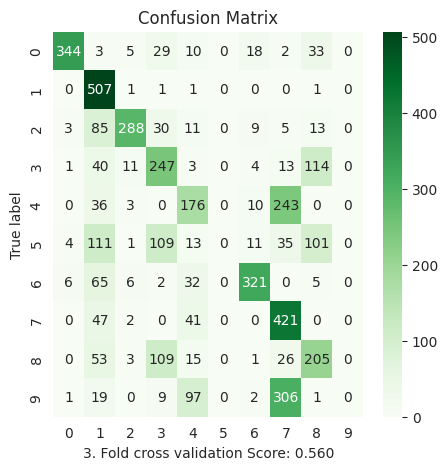

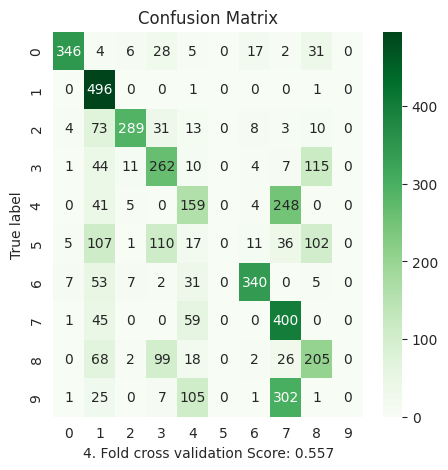

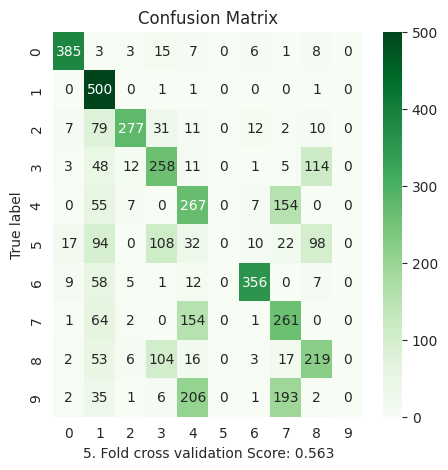

Average accuracy: 0.5596875


In [10]:
for i, score in enumerate(accuracy_scores_for_trainin_error):
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrices_for_trainin_error[i], annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    i+=1
    plt.xlabel(f'{i}. Fold cross validation Score: {score:.3f}')
    plt.plot()

plt.show()

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores_for_trainin_error)
print(f"Average accuracy: {avg_accuracy}")

### IMPORTANT NOTE
> As you can be seen from the tables, I created that in the operations performed by applying k fold cross, values in distributions are close to each other. To avoid this, I will try two separate approaches. 
> First is the approach I'm trying to implement here. The second solution would be to proceed to the result without applying k fold. When I try this, you will see that the distribution looks better.

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
# pd.set_option('display.max_columns', 7)

row_labels = [f'Label{i}' for i in range(10)]
column_labels = [f'Cluster{i+1}' for i in range(10)]

accuracy_scores_for_trainin_error = []
confusion_matrices_for_trainin_error = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
kmeans = KMeansWithCustomDistance(n_clusters=10, init='k-means++', distance='manhattan')
kmeans.fit(X_train)

cluster_labels = infer_cluster_labels(kmeans, y_train)
X_cluster_labels = kmeans.predict(X_train)
predicted_labels = infer_data_labels(X_cluster_labels, cluster_labels)

clusters = kmeans.labels_
label_counts = np.zeros((10, 10))

In [12]:
for i in range(len(clusters)):
    label_counts[clusters[i]][y_train[i]] += 1
    
conjucted_matrix = (pd.DataFrame(label_counts, index=row_labels, columns=column_labels))

### Training Error — Confusion Matrix & Accuracy

In [13]:
print(conjucted_matrix)

        Cluster1  Cluster2  Cluster3  Cluster4  Cluster5  Cluster6  Cluster7  \
Label0      10.0       1.0      14.0      13.0     210.0      23.0      42.0   
Label1      23.0       0.0      12.0       4.0      10.0      13.0     416.0   
Label2       0.0     329.0      30.0       1.0      22.0       1.0       2.0   
Label3       4.0     292.0      69.0      53.0      32.0     137.0      74.0   
Label4     438.0       0.0       4.0       1.0       0.0       5.0       9.0   
Label5      37.0       1.0      15.0     136.0       0.0     123.0       8.0   
Label6       6.0       1.0     352.0      16.0       4.0       1.0       7.0   
Label7       2.0       0.0       2.0       8.0     189.0      37.0       0.0   
Label8       1.0       0.0       3.0       3.0     122.0       6.0       0.0   
Label9      30.0       1.0      39.0     325.0       0.0     133.0       2.0   

        Cluster8  Cluster9  Cluster10  
Label0      73.0      23.0      140.0  
Label1       0.0       2.0        2.0  

### All label distribution in clusters

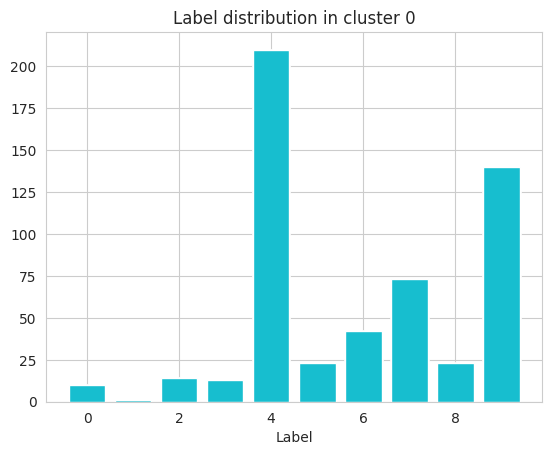

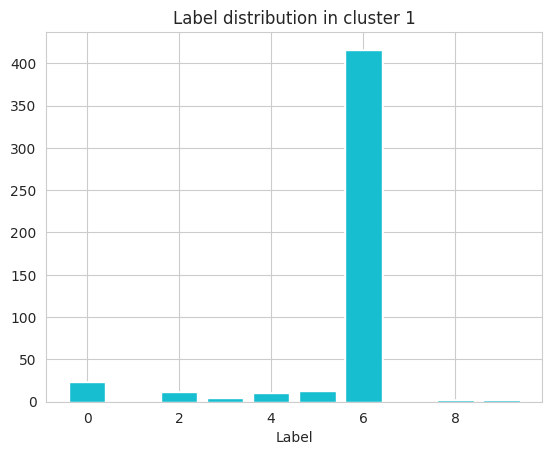

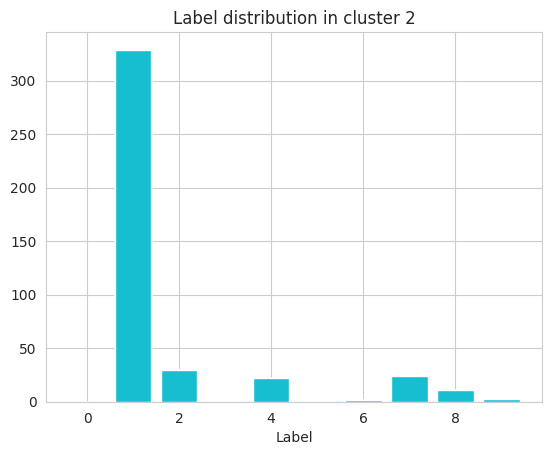

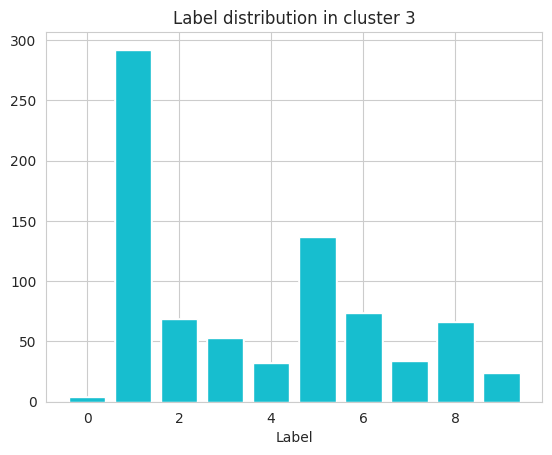

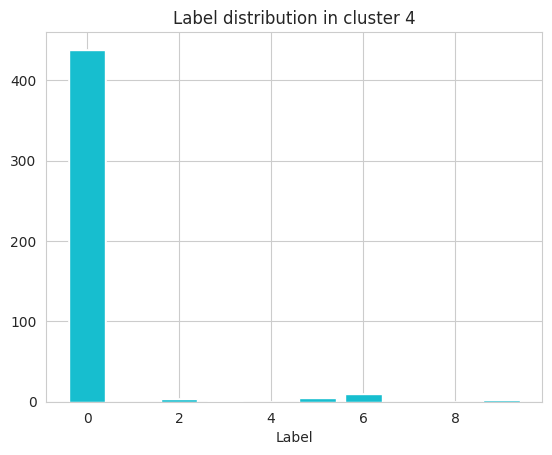

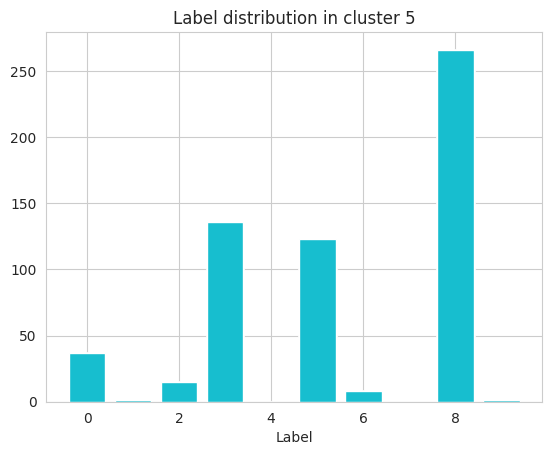

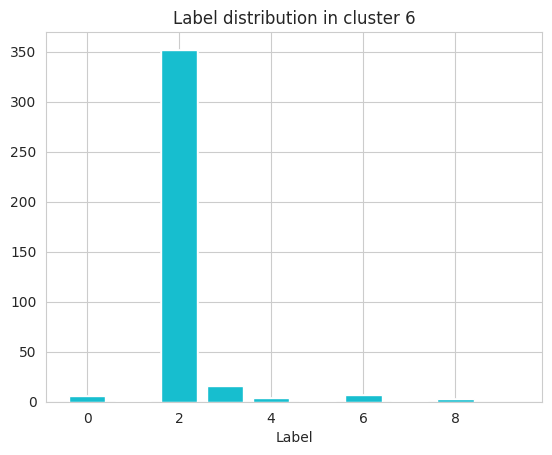

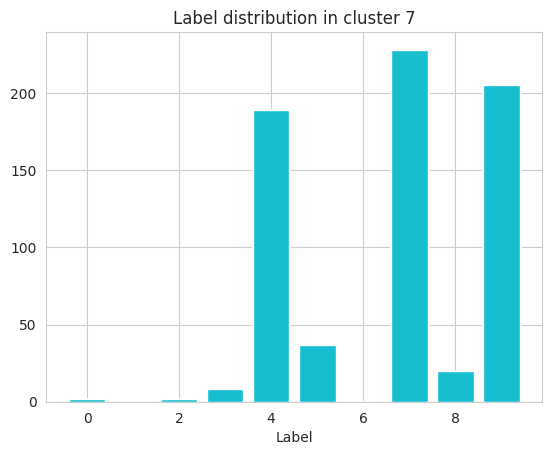

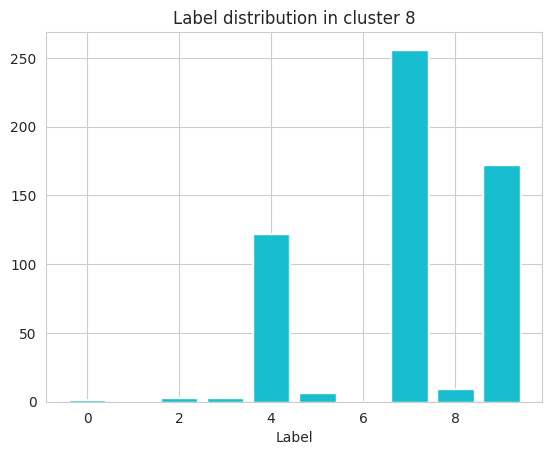

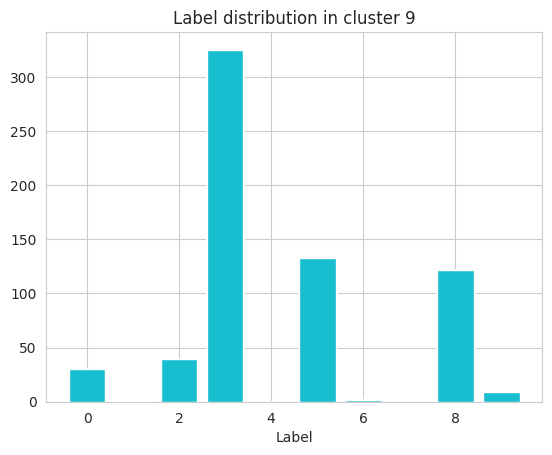

In [14]:
# if you want to see all label distribution in clusters, you will uncomment
for i in range(10):
    for j in range(10):
        plt.bar(range(10), label_counts[i])
        plt.title(f"Label distribution in cluster {i}")
        plt.xlabel("Label")
    plt.show()

In [15]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

ValueError: Found array with dim 3. KNeighborsClassifier expected <= 2.